\begin{center}
Gabe Morris
\end{center}

In [1]:
import control as ct
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../maroon_ipynb.mplstyle')

\pagebreak

\pagebreak
\tableofcontents
\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 3613 & Homework 5 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

# Problem 1
## Given

![Figure 1](f1.PNG)

The mass above is being controlled by the input position $y(t)$. Take $k_1=10\,\frac{lbf}{in}$, $k_2=100\,\frac{lbf}{in}$, $c_1=1\,\frac{lbf\,s}{in}$, and $m_1=0.0518\,goobs$ where $1\,goob=\frac{lbs\,s^2}{in}$. The number comes from the mass weighing $20\,lbf$.

$$
\begin{gathered}
W=mg \\
20\,lbf=m\cdot32.2\,\frac{ft}{s^2} \\
m=\frac{20}{32.2}\,slugs=0.621\,\frac{lbf\,s^2}{ft}\cdot\frac{ft}{12\,in}=0.0518\frac{lbf\,s^2}{in}=0.0518\,goobs
\end{gathered}
$$

## Find
For $y(t)=1.5\sin(\omega_r t)$, 

a. Find the equation of motion.
b. Find the transfer function $\frac{X(s)}{Y(s)}$.
c. Plot the Magnitude ($M(\omega)$ - not in decibels) and Phase Response for $1\le\omega\le1000\,rad/s$. Use the `bode()` function for checking. Note, the `bode()` function will produce a log-log plot on the y and x-axis, so the usual plot of $M(\omega)$ will look different, since we use a linear scale for the y-axis.
d. Find the resonant frequency $\omega_r$.
e. Find the steady state function $x_{ss}(t)$ at the resonant frequency and plot the forced response on top of the steady state response up to 1 second.

## Solution
### Part A

In [2]:
t, s, k1, k2, c1, m1 = sp.symbols('t s k1 k2 c1 m1')
x, y = sp.Function('x')(t), sp.Function('y')(t)

k1_, k2_ = 10, 100  # lbf/in
c1_ = 1  # lbs*s/in
m1_ = 0.0518  # goobs

eq = sp.Eq(m1*x.diff(t, 2), -k1*x - c1*x.diff() + k2*(y - x))
eq

Eq(m1*Derivative(x(t), (t, 2)), -c1*Derivative(x(t), t) - k1*x(t) + k2*(-x(t) + y(t)))

### Part B

In [3]:
lp = lambda expr: sp.laplace_transform(expr, t, s)[0]
eq_s = sp.Eq(lp(eq.lhs), lp(eq.rhs.expand()))

sub_ics = [
    (x.subs(t, 0), 0),
    (x.diff().subs(t, 0), 0)
]

eq_s = eq_s.subs(sub_ics)
eq_s

Eq(m1*s**2*LaplaceTransform(x(t), t, s), -c1*s*LaplaceTransform(x(t), t, s) - k1*LaplaceTransform(x(t), t, s) - k2*LaplaceTransform(x(t), t, s) + k2*LaplaceTransform(y(t), t, s))

In [4]:
T_s = sp.solve(eq_s, lp(x))[0]/lp(y)
T_s

k2/(c1*s + k1 + k2 + m1*s**2)

In [5]:
T = ct.tf(k2_, [m1_, c1_, k1_ + k2_])
T

TransferFunction(array([100]), array([5.18e-02, 1.00e+00, 1.10e+02]))

### Part C

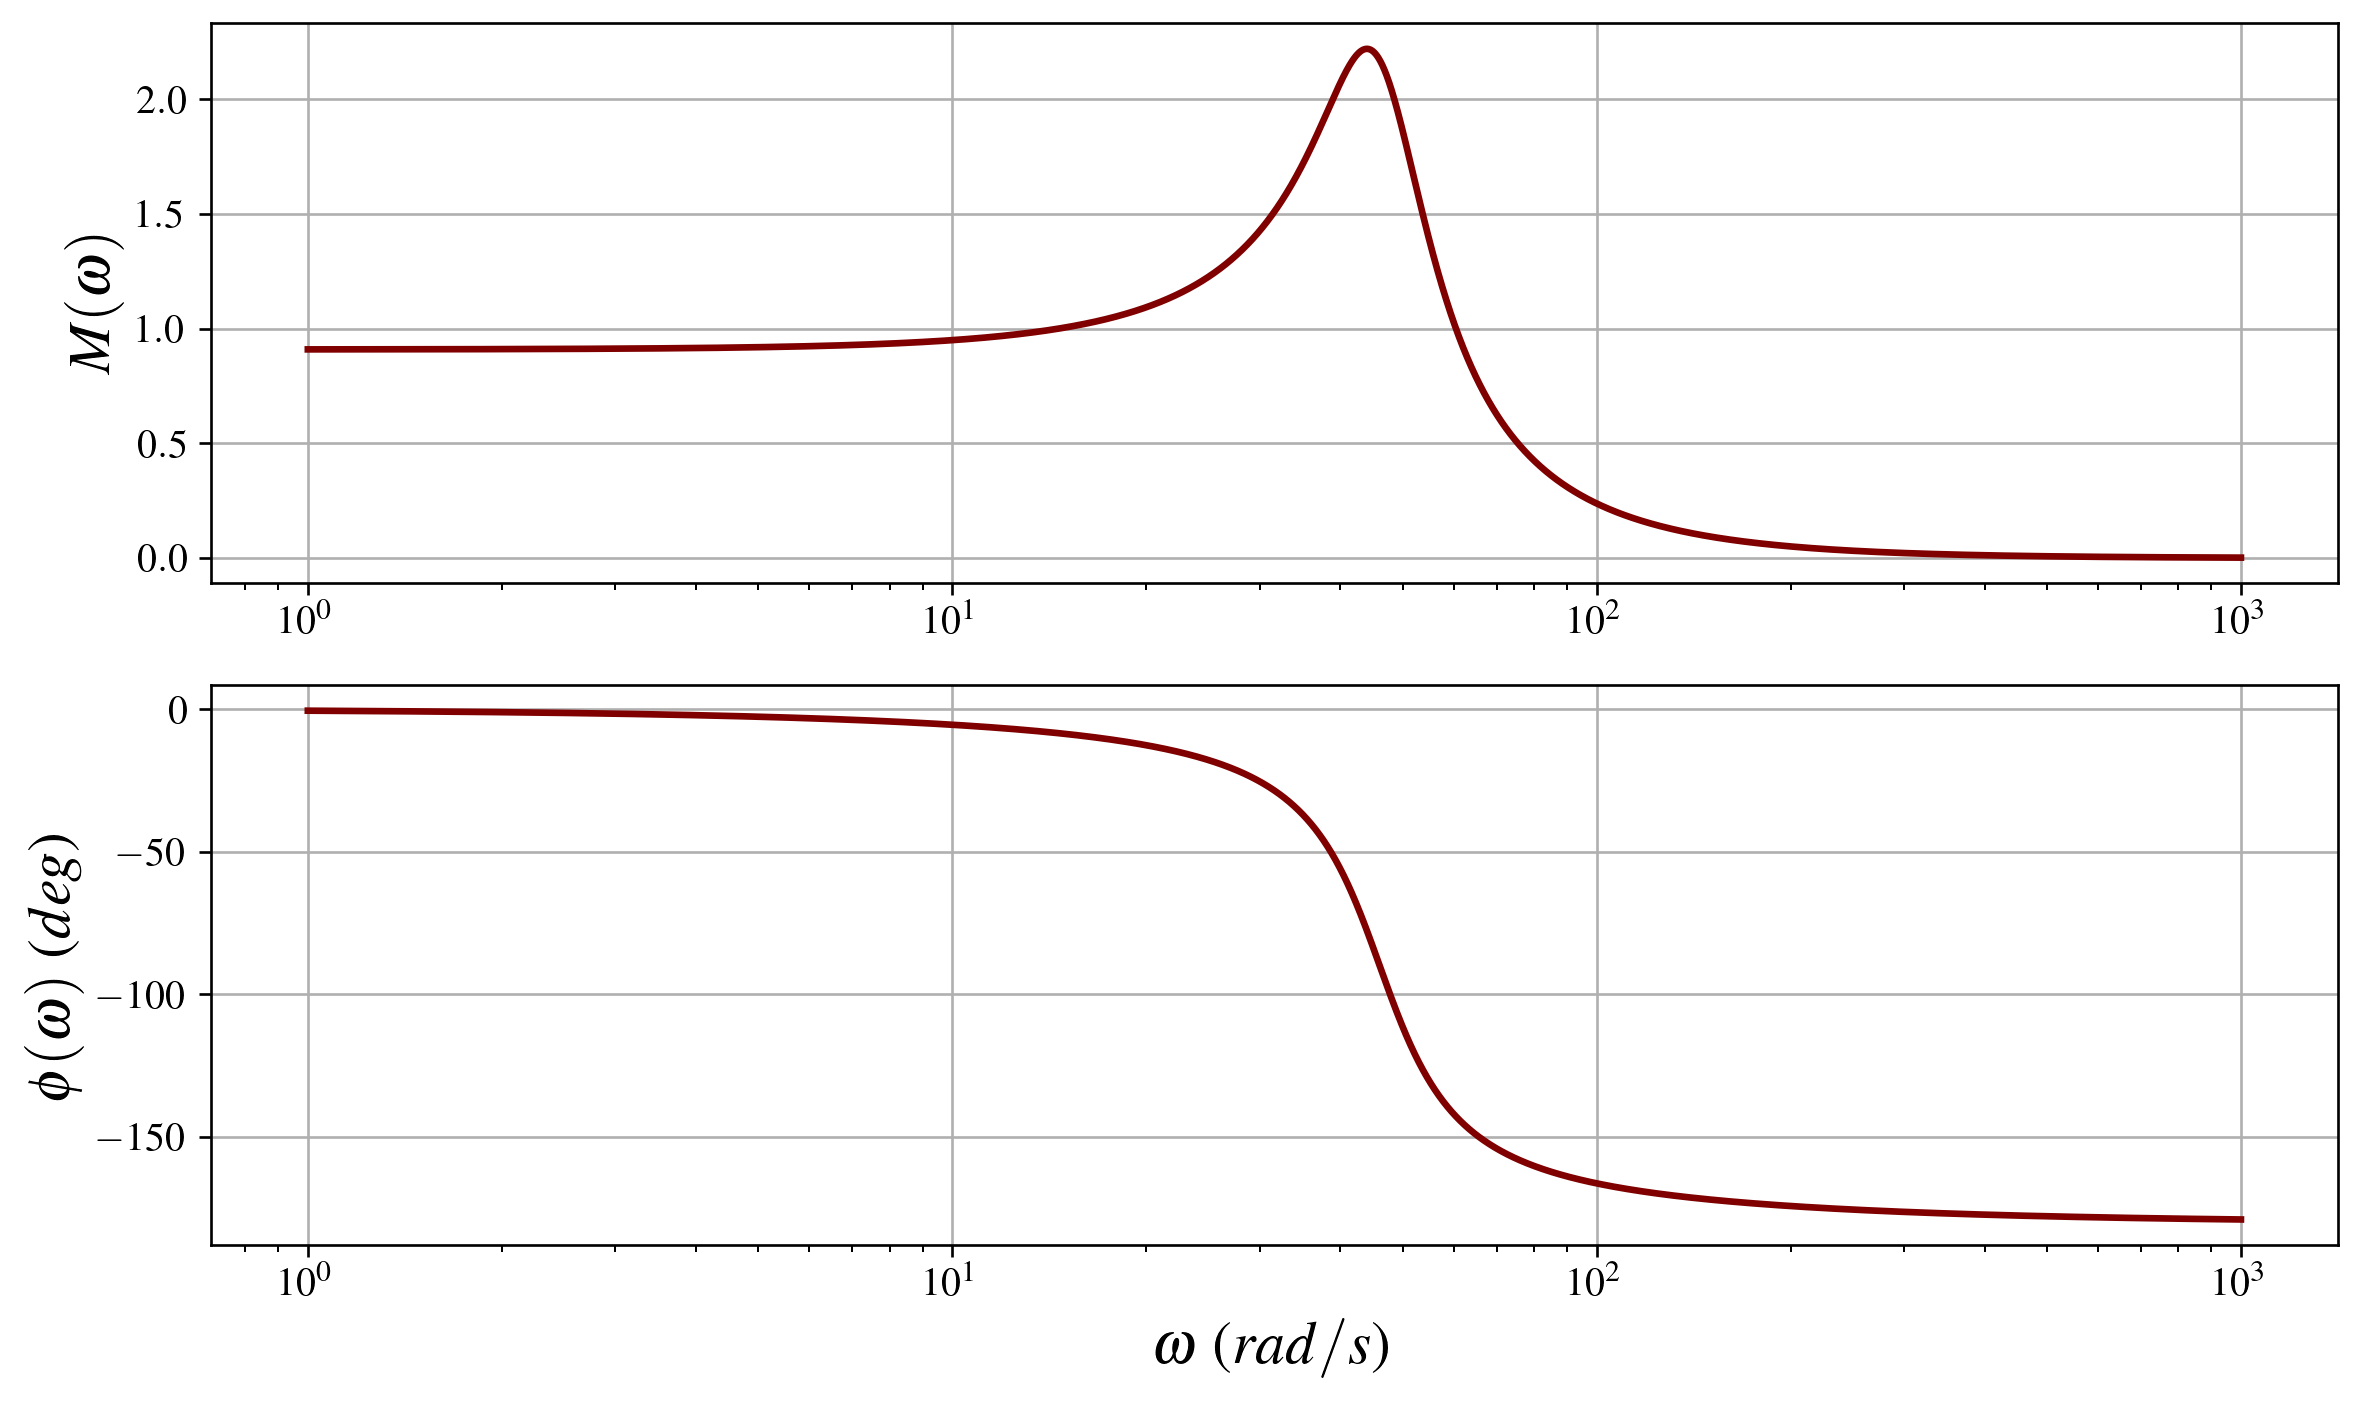

In [6]:
omega = sp.Symbol(r'\omega')
T_jw = sp.lambdify(omega, T_s.subs([
    (s, sp.I*omega),
    (k1, k1_),
    (k2, k2_),
    (c1, c1_),
    (m1, m1_)
]))

omegas = np.linspace(1, 1000, 100_000)
mags = np.abs(T_jw(omegas))
phase = np.angle(T_jw(omegas))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.set_xscale('log')
ax2.set_xscale('log')
# ax1.set_yscale('log')

ax1.plot(omegas, mags)
ax1.set_ylabel(r'$M(\omega)$')

ax2.plot(omegas, np.rad2deg(phase))
ax2.set_ylabel(r'$\phi(\omega)$ ($deg$)')
ax2.set_xlabel(r'$\omega$ ($rad/s$)')

# fig.savefig('Problem 1 Freq Response.png')
plt.show()

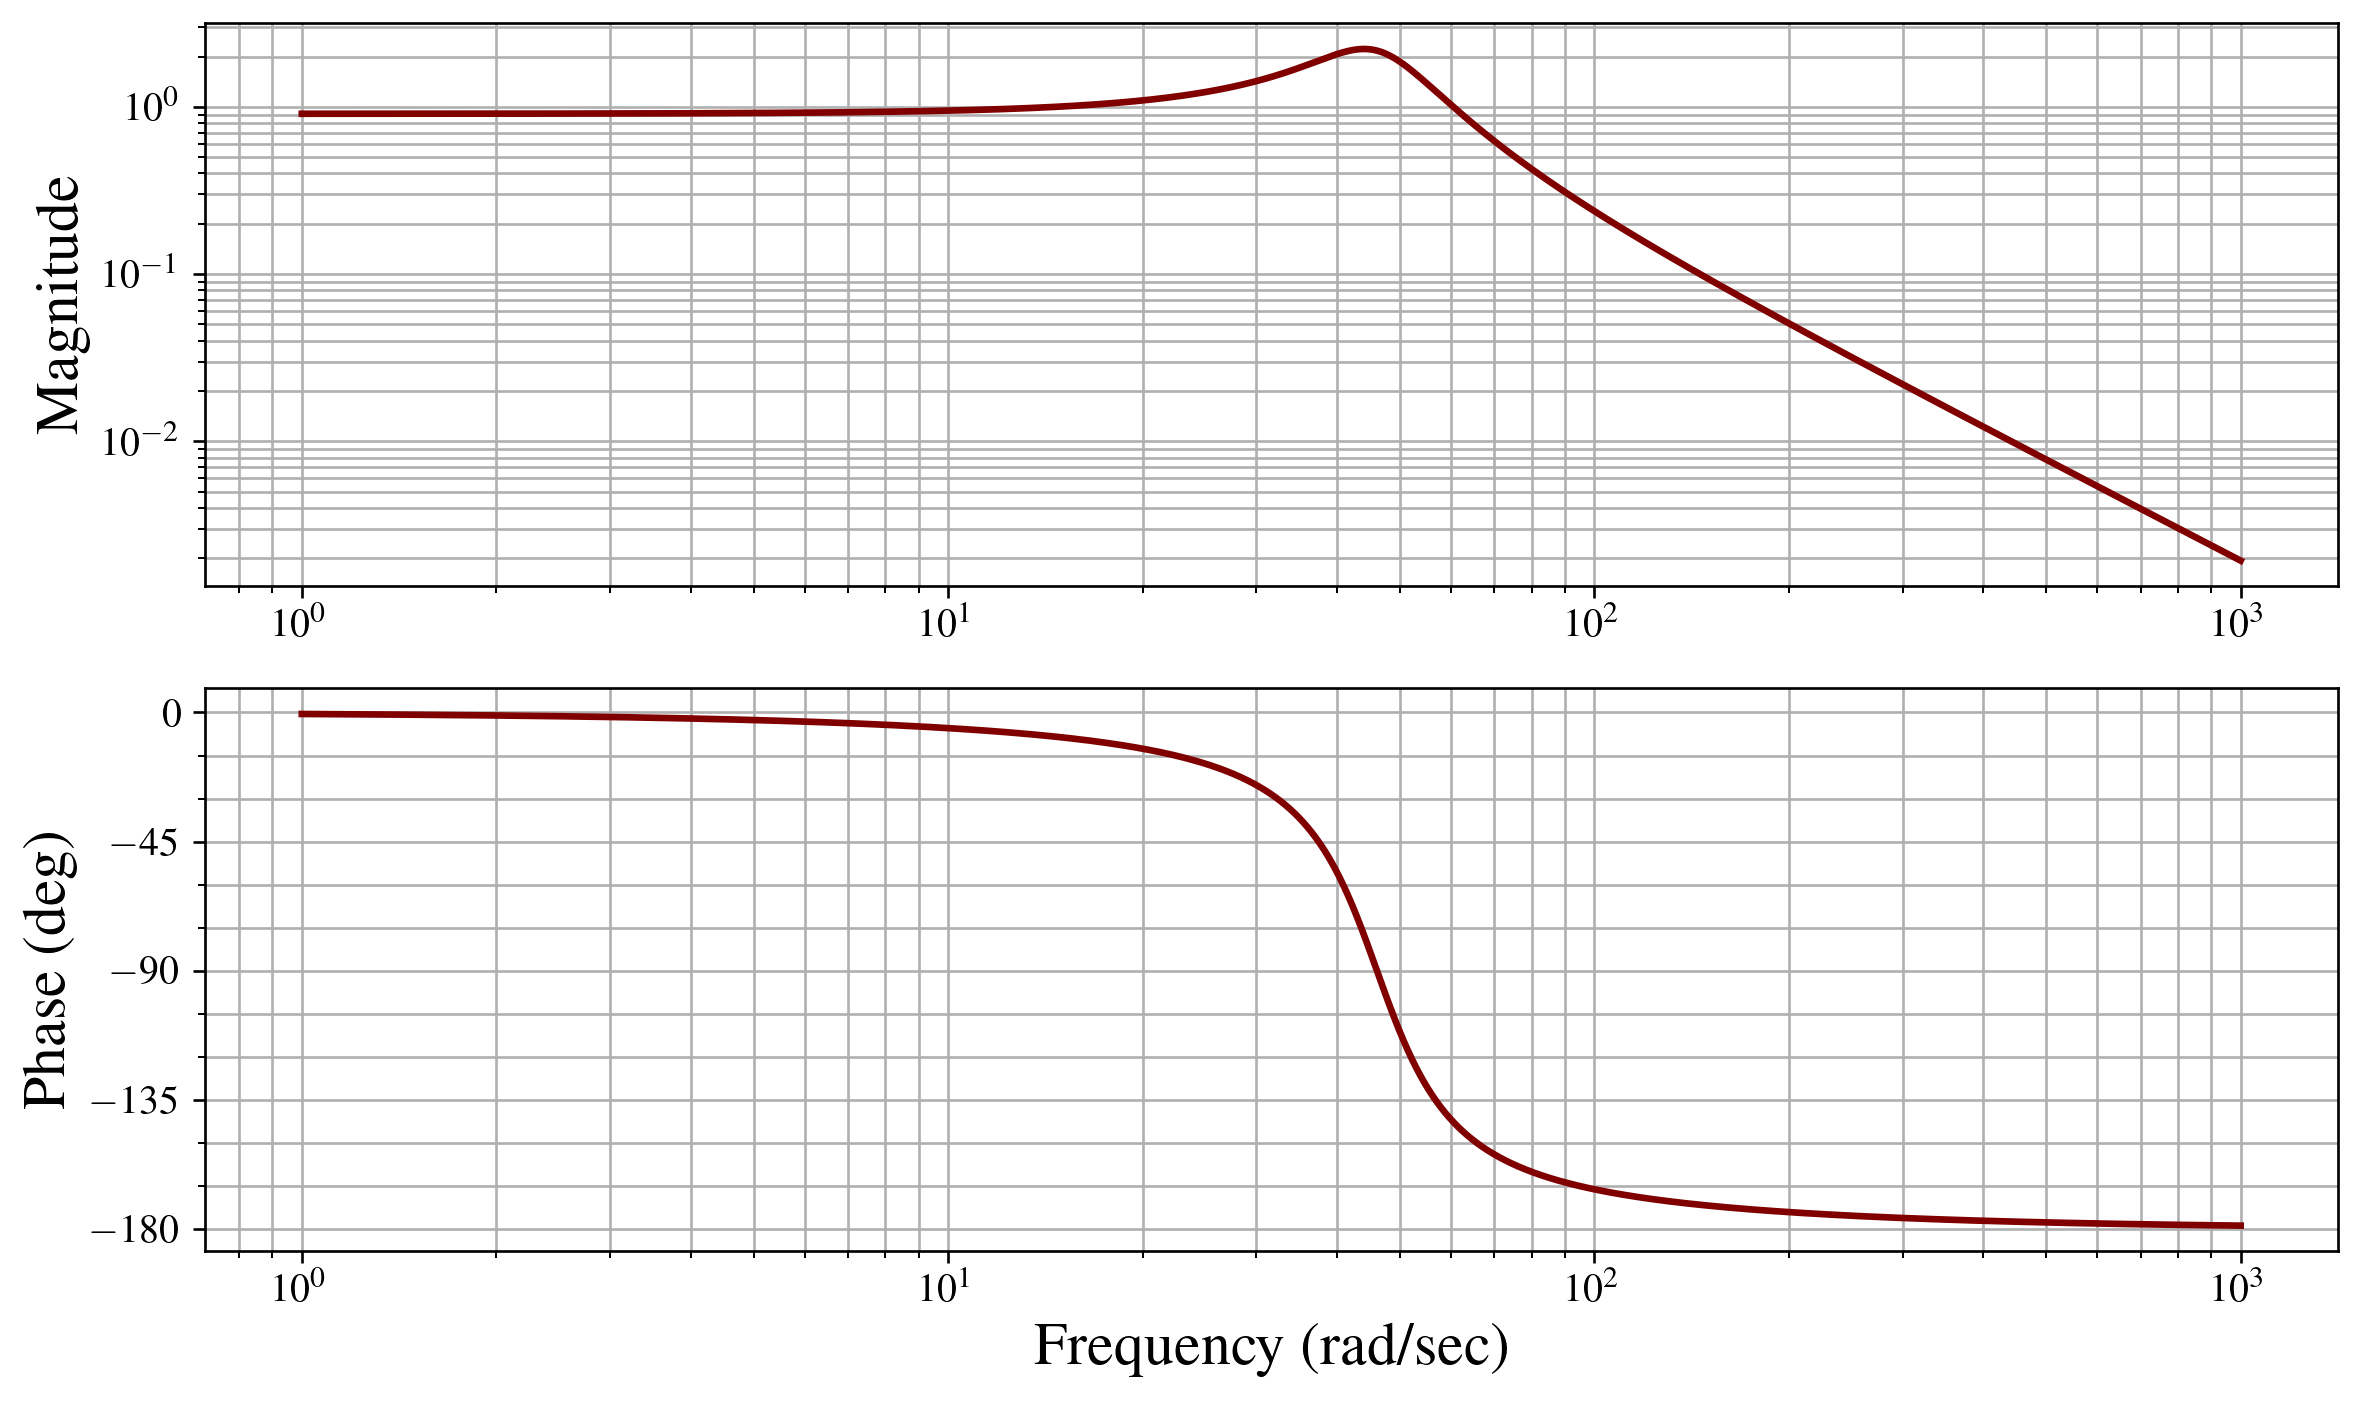

In [7]:
# For checking
_ = ct.bode(T, omega=omegas)  # There is unwanted behavior to where the magnitude y-axis is logarithmic. I checked and there is no changing it.

### Part D

In [8]:
(wn, _), (zeta, _), (root, _) = ct.damp(T)

    Eigenvalue (pole)       Damping     Frequency
    -9.653    +45.06j        0.2095         46.08
    -9.653    -45.06j        0.2095         46.08


In [9]:
wr = wn*np.sqrt(1 - 2*zeta**2)
wr  # rad/s

44.01375056012086

In [10]:
# Could also do something like this
omegas[max(mags) == mags][0]

44.017370173701735

### Part E

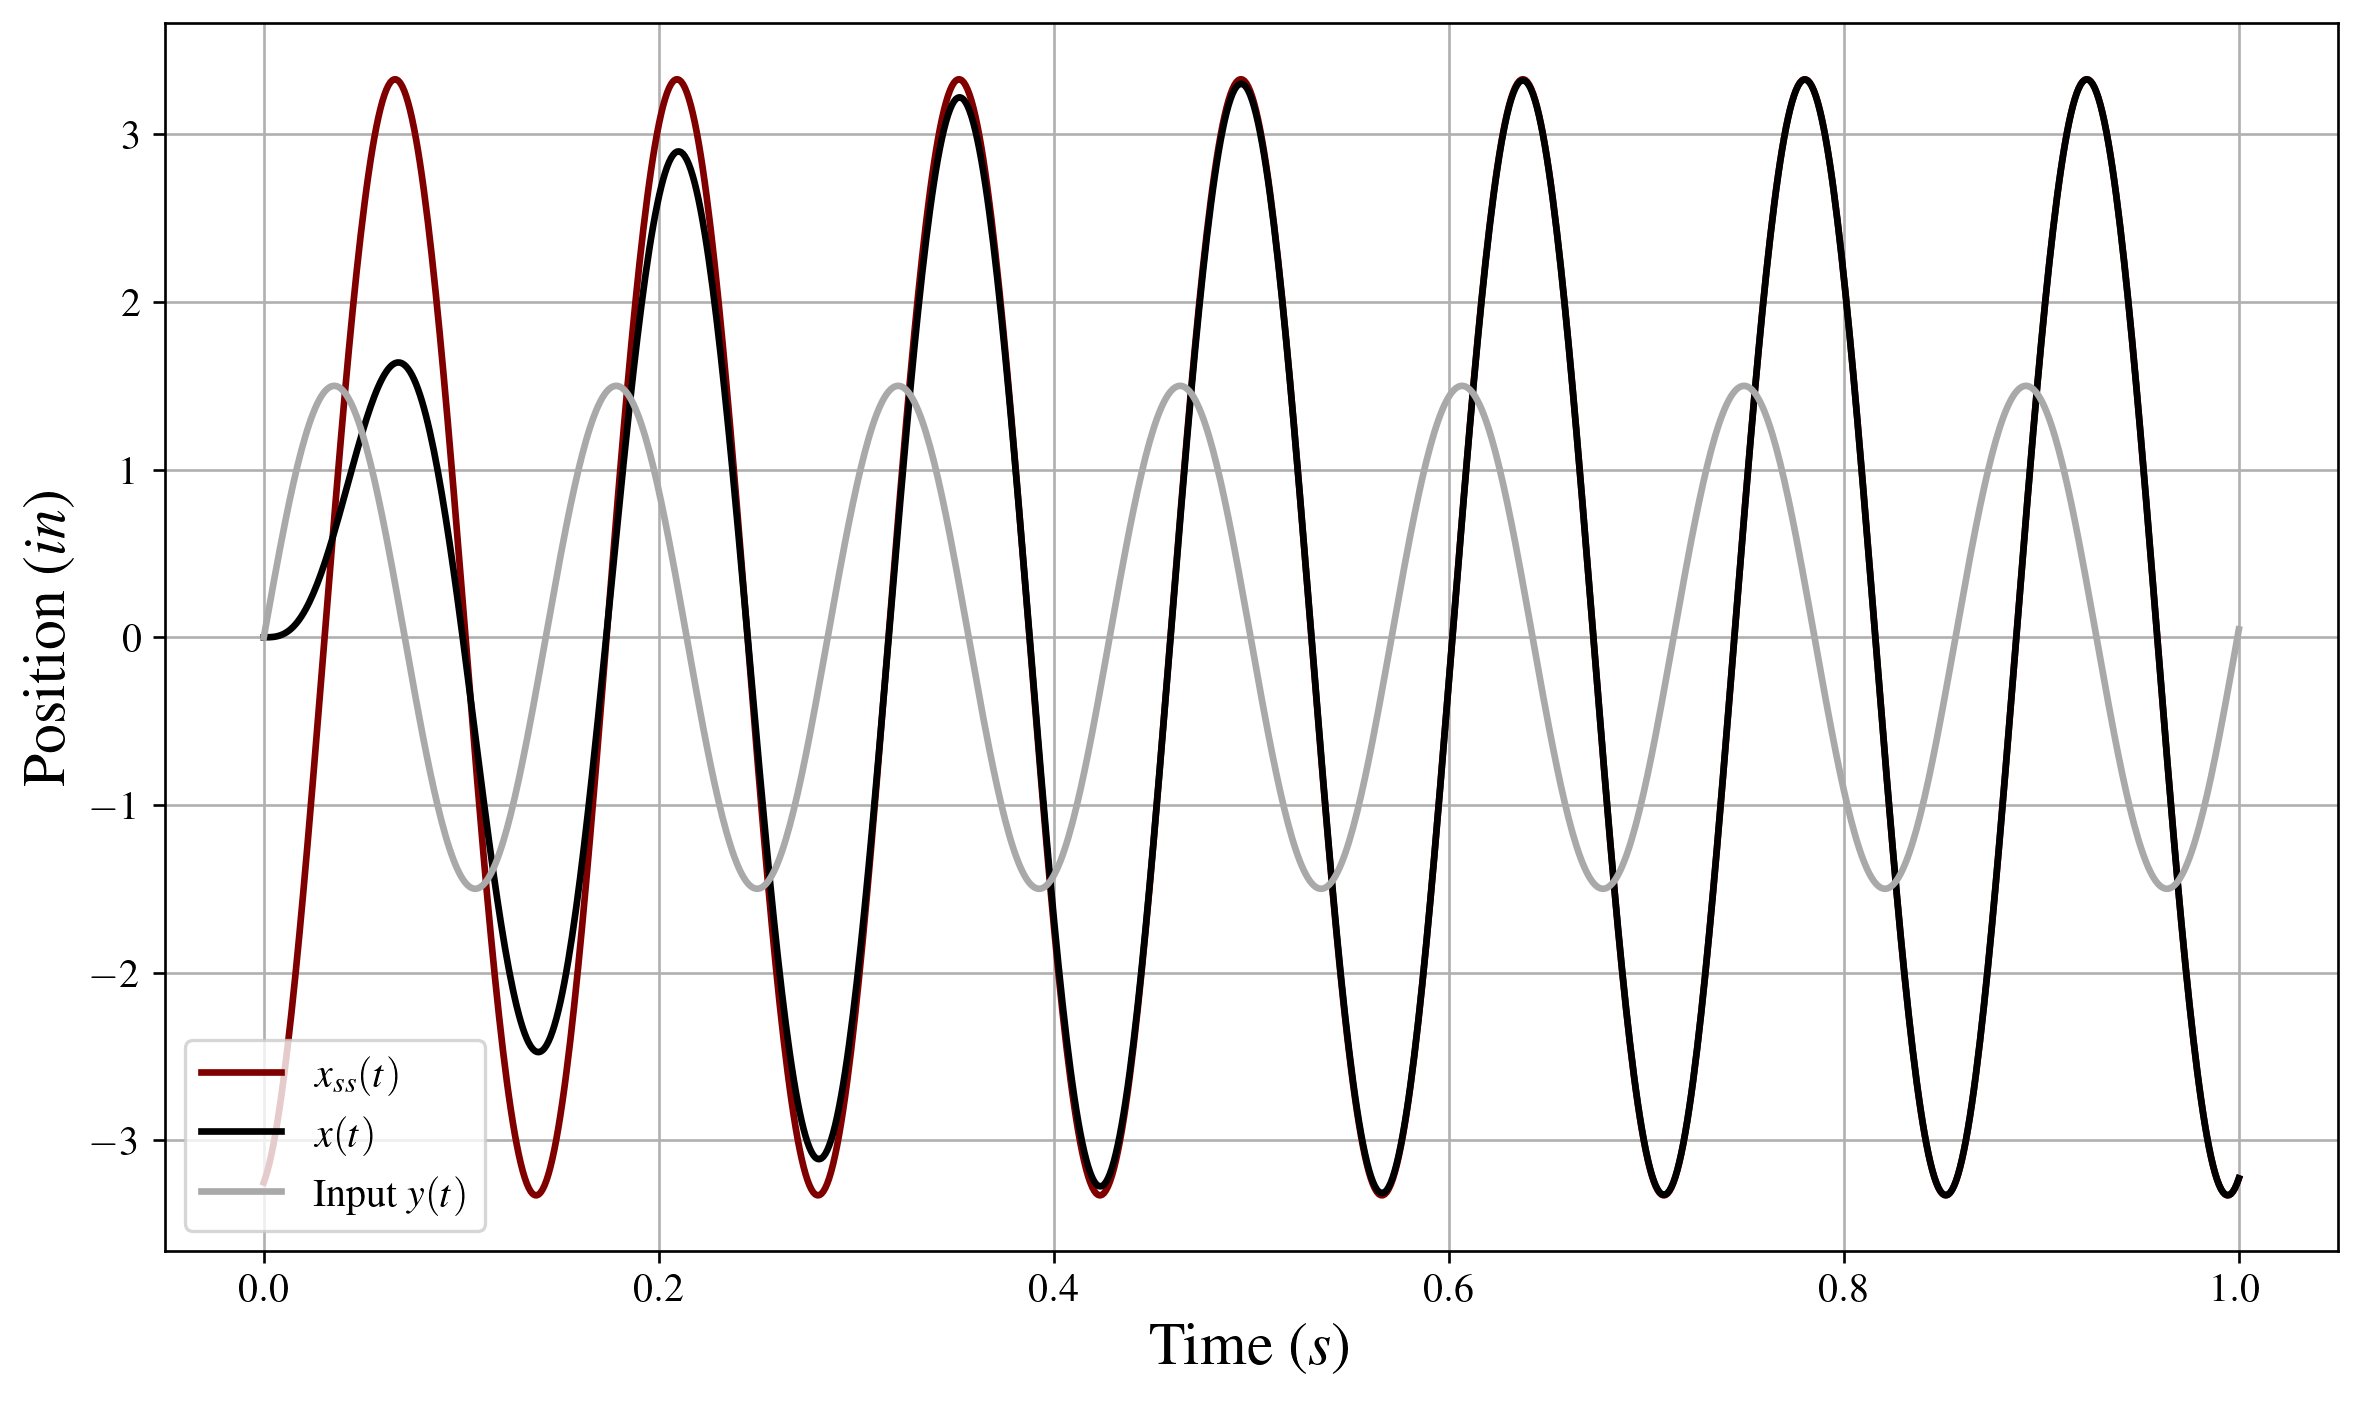

In [11]:
phi = np.angle(T_jw(wr))
B = 1.5*np.abs(T_jw(wr))
x_ss = lambda t_: B*np.sin(wr*t_ + phi)

t_array = np.linspace(0, 1, 1000)
_, x_ = ct.forced_response(T, T=t_array, U=1.5*np.sin(wr*t_array))

fig, ax = plt.subplots()

ax.plot(t_array, x_ss(t_array), label='$x_{ss}(t)$')
ax.plot(t_array, x_, label='$x(t)$')
ax.plot(t_array, 1.5*np.sin(wr*t_array), label='Input $y(t)$')

ax.legend()
ax.set_xlabel('Time ($s$)')
ax.set_ylabel('Position ($in$)')
# fig.savefig('Problem 1 Response.png')
plt.show()